In [29]:
# import necessary modules
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
import os
import warnings
#from datetime import datetime
from scipy import stats
from scipy.stats import norm, skew, probplot 
warnings.filterwarnings('ignore')
from datetime import datetime

In [41]:
def add_day(df):
    df['Date'] = df.index
    df['Dayofyear'] =df['Date'].dt.dayofyear
    return df

In [42]:
icu_CH =pd.read_csv("https://raw.githubusercontent.com/daenuprobst/covid19-cases-switzerland/master/covid19_icu_switzerland_openzh.csv")
confirmedT = icu_CH[["Date", "CH"]].rename(columns={"CH":"Switzerland"})
confirmedT["Date"] =  pd.to_datetime(confirmedT["Date"])
confirmedT = confirmedT.set_index("Date")
confirmedT = add_day(confirmedT)            

In [43]:
def create_lags(df, maxshift):
    # Shifts
    shifts = np.arange(1,maxshift+1)
    # Create a dictionary of time-shifted data
    many_shifts = {'lag_{}'.format(ii): df.shift(ii) for ii in shifts}
    # Convert them into a dataframe
    many_shifts = pd.DataFrame(many_shifts).fillna(0.)
    return many_shifts

In [44]:
# Accuracy metrics
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    rmsle = np.sqrt(np.mean((np.log(forecast+1)-np.log(actual+1))**2))
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # Mean Absolute Percentage Error
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    #acf1 = acf(fc-test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 'rmsle' : rmsle,
            'mpe': mpe, 'rmse':rmse, #'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

In [47]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
# define list of models and parameters
list_models = [('ElasticNet', ElasticNet()),
                ('ElasticNet_wdiff', ElasticNet()),
                ('ElasticNet_wdiffwrolling', ElasticNet())
               
              ]
#
list_params = [{'alpha' : np.logspace(-4,2,10),
                'l1_ratio' : np.array([0.6,0.7,0.8,0.9,1.])},
                {'alpha' : np.logspace(-4,2,10),
                'l1_ratio' : np.array([0.6,0.7,0.8,0.9,1.])},
                {'alpha' : np.logspace(-4,2,10),
                'l1_ratio' : np.array([0.6,0.7,0.8,0.9,1.])},
              ]
order_countries = ["Switzerland"]

In [61]:
Nlags = 1
list_inpdate = ['Dayofyear']
list_rescv = ['params', 'mean_test_score', 'std_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score']
#
list_train_fc = [] ; list_valid_fc = [] ; list_train = [] ; list_valid = []
list_confirmed_train_fc = [] ; list_confirmed_valid_fc = [] ; list_confirmed_train = [] ; list_confirmed_valid = []
list_bestparams = [] ; list_bestest = [] ; list_cvres = [] ; list_inpfeat = [] ; list_error = []
df_error = pd.DataFrame(index=order_countries)
#
for im, model in enumerate(list_models): 
    list_bestparams2 = [] ; list_bestest2 = [] ; list_cvres2 = [] ; list_inpfeat2 = []
    list_train_fc2 = [] ; list_valid_fc2 = [] ; list_train2 = [] ; list_valid2 = []
    list_confirmed_train_fc2 = [] ; list_confirmed_valid_fc2 = [] ; list_confirmed_train2 = [] ; list_confirmed_valid2 = []
    list_error2 = [] ; list_index = []
    for ic, country in enumerate(order_countries): 
        print('Analyzing '+country+' with '+model[0])
        #
        # here the daily number of confirmed cases is used to make the TS more stationary, 
        # a rolling mean of 2 is also used to smooth the curves since some data are not updated on a daily basis
        inpfeature = list_inpdate + ['lag_'+str(i+1) for i in range(Nlags)] # + list_inpfeat 
        #
        if im == 0: # model directly the total number of confirmed cases
            dfcountry = confirmedT[[country, 'Dayofyear']].replace([np.inf, -np.inf], np.nan).dropna() 
        elif im == 1: # model the daily number of new confirmed cases
            dfcountry = confirmedT[[country, 'Dayofyear']].diff().rolling(1).mean().replace([np.inf, -np.inf], np.nan).dropna() 
        elif im == 2: # model the daily number of new confirmed cases averaged over a week (to smooth the data)
            dfcountry = confirmedT[[country, 'Dayofyear']].diff().rolling(7).mean().replace([np.inf, -np.inf], np.nan).dropna() 
        #
       
        
        dflag = create_lags(dfcountry[country], Nlags)
        masktrain =  dfcountry.index <= datetime(2020,3,21)
        datetrain, datevalid = dfcountry[masktrain].index[0], dfcountry[masktrain].index[-1] 
        dfconfirmedcountry = confirmedT[[country, 'Dayofyear']].replace([np.inf, -np.inf], np.nan).dropna() 
        confirmedstart = dfconfirmedcountry.loc[datetrain,country]
        confirmedend = dfconfirmedcountry.loc[datevalid,country]
        #
        # join all features
        dftrain2 = dflag[masktrain].join(dfcountry[masktrain])
        dfvalid2 = dflag[~masktrain].join(dfcountry[~masktrain])
        if ic > 0: # and im == 1
            inpfeature += order_countries[:ic]
            for ic2 in range(ic):
                dftrain2 = dftrain2.join(list_train2[ic2])
                dfvalid2 = dfvalid2.join(list_valid2[ic2])
        #
        # define training and validation sets
        X = dftrain2[inpfeature]#.drop(country, axis=1)
        y = dftrain2[country] 
        print(X)
        X_valid = dfvalid2[inpfeature]#.drop(country, axis=1)
        y_valid = dfvalid2[country]
        # 
        # run grid search
        param_search = list_params[im]
        tscv = TimeSeriesSplit(n_splits=5)
        gsearch = GridSearchCV(estimator=model[1],        # choice of model
                               cv=tscv,                   # choice of splitting
                               param_grid=param_search,   # grid of parameters
                               verbose=1,                 # print messages
                               return_train_score=True,   # return train score in CV grid result
                               n_jobs=-1,                 # number of CPUs to be used
                               scoring='neg_mean_squared_error' # metrics to be used
                              )
        gsearch.fit(X, y)
        #
        # save results
        list_bestparams2.append(gsearch.best_params_)
        list_bestest2.append(gsearch.best_estimator_)
        cvres = pd.DataFrame(gsearch.cv_results_)[list_rescv].sort_values(by='rank_test_score',ascending=True)
        list_cvres2.append(cvres)
        #print(cvres.head())
        print('Best-fit parameters: ',gsearch.best_params_,'\n \n')
        #
        # get the forecast TS
        #n_periods = len(valid.index)
        valid_fc = pd.Series(gsearch.predict(X_valid), index=X_valid.index) #gsearch.predict(X_valid) 
        train_fc = pd.Series(gsearch.predict(X), index=X.index) #gsearch.predict(X)
        #
        # save the forecast 
        list_train2.append(y) ; list_valid2.append(y_valid)
        list_train_fc2.append(train_fc) ; list_valid_fc2.append(valid_fc)
        list_inpfeat2.append(inpfeature)
        #
        # re-compute number of confirmed cases
        if im == 0: 
            list_confirmed_train2.append(y) ; list_confirmed_valid2.append(y_valid)
            list_confirmed_train_fc2.append(train_fc) ; list_confirmed_valid_fc2.append(valid_fc)
        elif im == 1: # 
            list_confirmed_train2.append(y.cumsum()+confirmedstart) ; list_confirmed_valid2.append(y_valid.cumsum()+confirmedend)
            list_confirmed_train_fc2.append(train_fc.cumsum()+confirmedstart) ; list_confirmed_valid_fc2.append(valid_fc.cumsum()+confirmedend)
        elif im == 2: 
            #ytrain = (confirmedT[[country, 'Dayofyear']].diff().dropna()).loc[:datetime.datetime(2020,3,15),country]
            #yvalid = (confirmedT[[country, 'Dayofyear']].diff().dropna()).loc[datetime.datetime(2020,3,15):,country]
            list_confirmed_train2.append(y.cumsum()+confirmedstart) ; list_confirmed_valid2.append(y_valid.cumsum()+confirmedend)
            list_confirmed_train_fc2.append(train_fc.cumsum()+confirmedstart) ; list_confirmed_valid_fc2.append(valid_fc.cumsum()+confirmedend)
        #
        # evaluate the error
        list_error2.append(forecast_accuracy(list_confirmed_valid_fc2[-1], list_confirmed_valid2[-1])['rmsle'])
        #list_index.append(storedept)

    #
    list_train.append(list_train2) ; list_valid.append(list_valid2)
    list_train_fc.append(list_train_fc2) ; list_valid_fc.append(list_valid_fc2)
    list_confirmed_train.append(list_confirmed_train2) ; list_confirmed_valid.append(list_confirmed_valid2)
    list_confirmed_train_fc.append(list_confirmed_train_fc2) ; list_confirmed_valid_fc.append(list_confirmed_valid_fc2)
    list_bestparams.append(list_bestparams2) ; list_bestest.append(list_bestest2) ; list_cvres.append(list_cvres2)
    list_inpfeat.append(list_inpfeat2)
    #
    df_error['RMSLE_'+model[0]] = list_error2 

Analyzing Switzerland with ElasticNet
            Dayofyear  lag_1
Date                        
2020-02-25         56    0.0
2020-02-26         57    0.0
2020-02-27         58    0.0
2020-02-28         59    0.0
2020-02-29         60    0.0
2020-03-01         61    0.0
2020-03-02         62    0.0
2020-03-03         63    0.0
2020-03-04         64    0.0
2020-03-05         65    1.0
2020-03-06         66    1.0
2020-03-07         67    2.0
2020-03-08         68    4.0
2020-03-09         69    3.0
2020-03-10         70    9.0
2020-03-11         71   11.0
2020-03-12         72   14.0
2020-03-13         73   15.0
2020-03-14         74   31.0
2020-03-15         75   36.0
2020-03-16         76   45.0
2020-03-17         77   51.0
2020-03-18         78   69.0
2020-03-19         79   69.0
2020-03-20         80   92.0
2020-03-21         81   96.0
Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Best-fit parameters:  {'alpha': 0.0001, 'l1_ratio': 0.6} 
 

Analyzing Switzerland with ElasticNet_wdiff
            Dayofyear  lag_1
Date                        
2020-02-26        1.0    0.0
2020-02-27        1.0    0.0
2020-02-28        1.0    0.0
2020-02-29        1.0    0.0
2020-03-01        1.0    0.0
2020-03-02        1.0    0.0
2020-03-03        1.0    0.0
2020-03-04        1.0    0.0
2020-03-05        1.0    1.0
2020-03-06        1.0    0.0
2020-03-07        1.0    1.0
2020-03-08        1.0    2.0
2020-03-09        1.0   -1.0
2020-03-10        1.0    6.0
2020-03-11        1.0    2.0
2020-03-12        1.0    3.0
2020-03-13        1.0    1.0
2020-03-14        1.0   16.0
2020-03-15        1.0    5.0
2020-03-16        1.0    9.0
2020-03-17        1.0    6.0
2020-03-18        1.0   18.0
2020-03-19        1.0    0.0
2020-03-20        1.0   23.0
2020-03-21        1.0    4.0
Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Best-fit parameters:  {'alpha': 21.54434690031882, 'l1_ratio': 0.6} 
 

Analyzing Switzerland with ElasticNet_wdiffwrolling
            Dayofyear      lag_1
Date                            
2020-03-03        1.0   0.000000
2020-03-04        1.0   0.000000
2020-03-05        1.0   0.142857
2020-03-06        1.0   0.142857
2020-03-07        1.0   0.285714
2020-03-08        1.0   0.571429
2020-03-09        1.0   0.428571
2020-03-10        1.0   1.285714
2020-03-11        1.0   1.571429
2020-03-12        1.0   1.857143
2020-03-13        1.0   2.000000
2020-03-14        1.0   4.142857
2020-03-15        1.0   4.571429
2020-03-16        1.0   6.000000
2020-03-17        1.0   6.000000
2020-03-18        1.0   8.285714
2020-03-19        1.0   7.857143
2020-03-20        1.0  11.000000
2020-03-21        1.0   9.285714
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best-fit parameters:  {'alpha': 0.00046415888336127773, 'l1_ratio': 0.6} 
 



[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    0.4s finished


In [62]:
df_error.head(10)

,RMSLE_ElasticNet,RMSLE_ElasticNet_wdiff,RMSLE_ElasticNet_wdiffwrolling
Switzerland,0.084805,0.510844,0.037316


In [63]:
# Compare predicted and actual test TS
def plot_forecast(country, train, trainfc, valid, validfc, validfclower, validfcupper, plottitle):
    #fig, axes = plt.subplots(1, 1, figsize=(10,3), dpi=100, sharex=True)
    plt.xticks(rotation=15)
    plt.plot(train, label='Training set', color='C0')
    plt.plot(trainfc, label='Training set forecast', color='C0', ls='--')
    plt.plot(valid, label='Validation set', color='C1', ls='-')
    plt.ylabel('Confirmed cases')
    try:
        plt.fill_between(validfclower.index, 
                         validfclower, 
                         validfcupper, 
                         color='k', alpha=.15)
    except:
        pass
    plt.plot(validfc, label='Validation set forecast', color='C1', ls='--')
    plt.legend()
    plt.title("Forecast of "+str(country)+" with "+plottitle)
    #plt.show()

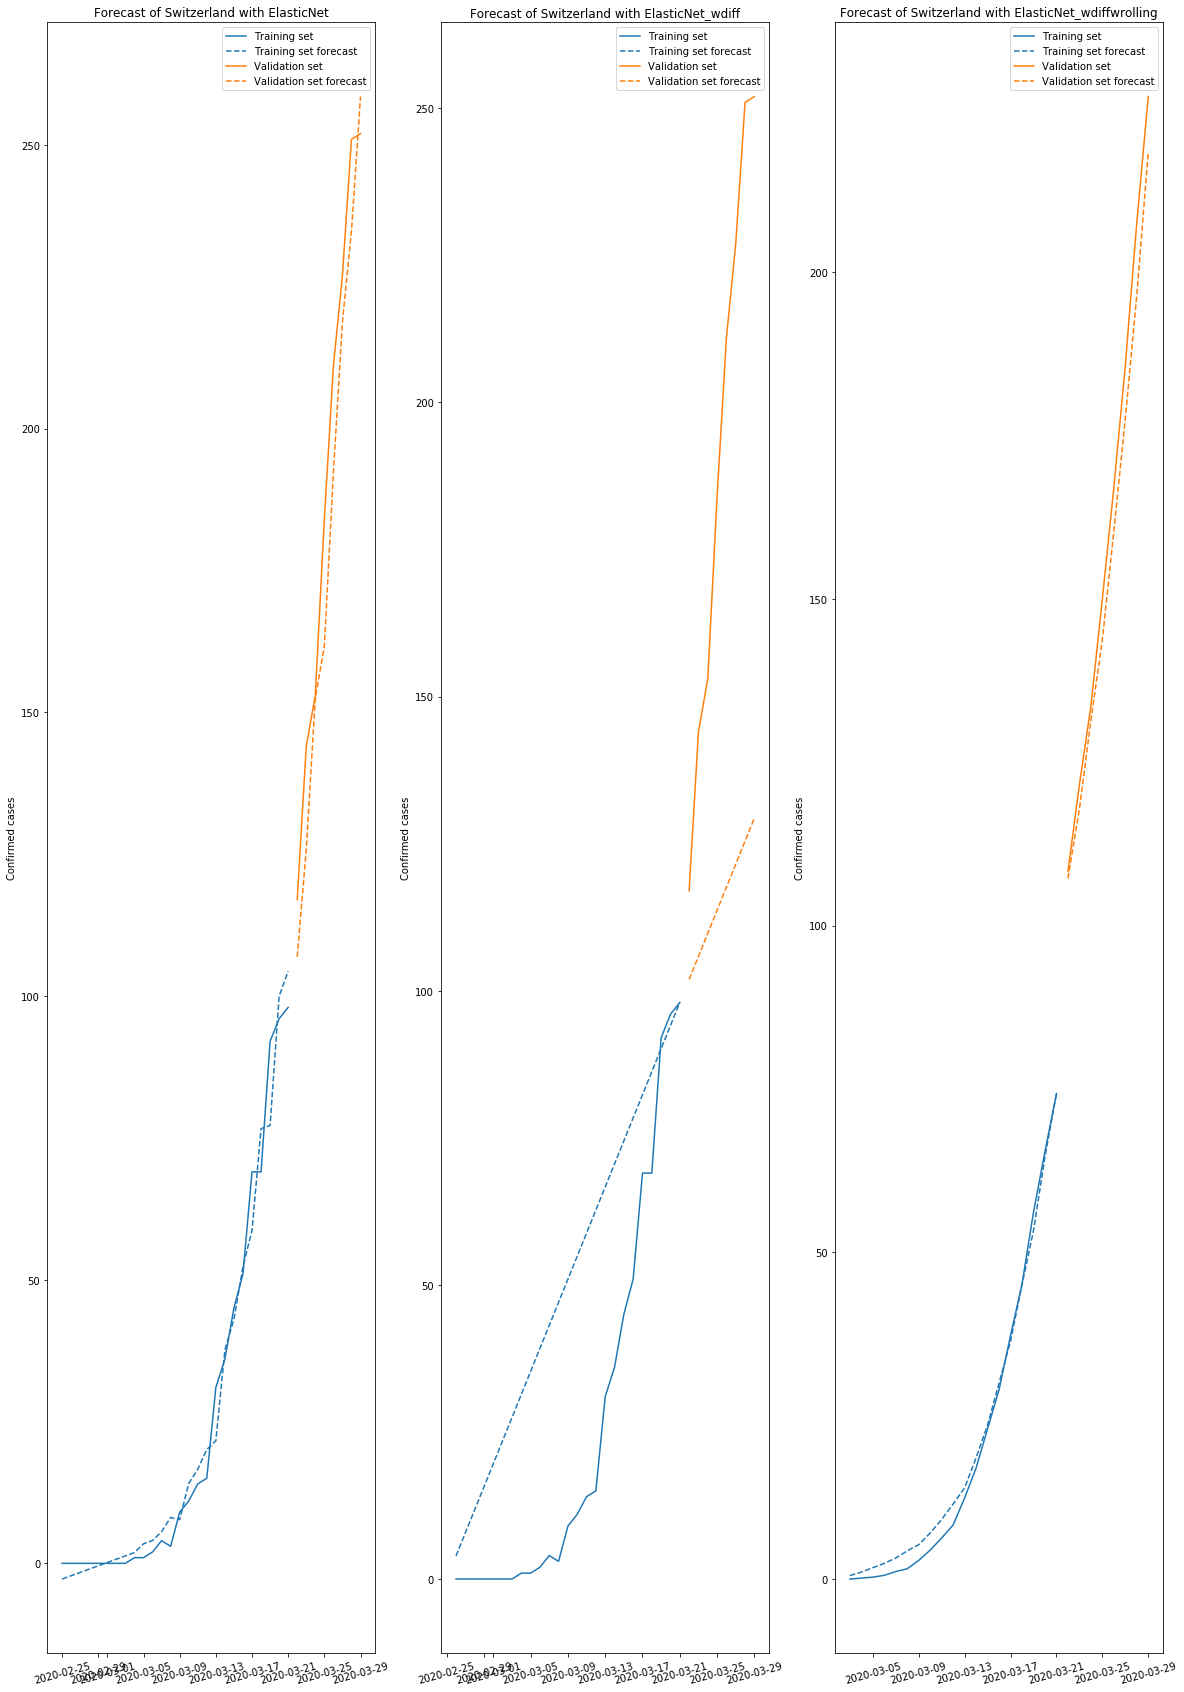

In [64]:
plt.figure(0,figsize=[20,30])
plt.subplots_adjust(wspace=0.2, hspace=0.45)
iy = 0
for ic, country in enumerate(order_countries): #allcountries_ordered:
    for im, model in enumerate(list_models): 
        plt.subplot(len(order_countries),len(list_models), iy+1)
        train = list_confirmed_train[im][ic] ; valid = list_confirmed_valid[im][ic]
        train_fc = list_confirmed_train_fc[im][ic] ; valid_fc = list_confirmed_valid_fc[im][ic]
        plot_forecast(country, train, train_fc, valid, valid_fc, 0., 0., model[0])
        iy += 1
plt.show()